## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [5]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [6]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",
                        no_wifi = "B28002_013" # no internet connection
                      ), 
                      year = 2023,
                      survey="acs5",
                      geometry=T)

nyc_census_data


Simple feature collection with 4654 features and 5 fields (with 6 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                        NAME   variable estimate
1  36005023502 Census Tract 235.02; Bronx County; New York population     4284
2  36005023502 Census Tract 235.02; Bronx County; New York    no_wifi      225
3  36005013500    Census Tract 135; Bronx County; New York population     3295
4  36005013500    Census Tract 135; Bronx County; New York    no_wifi      171
5  36005009200     Census Tract 92; Bronx County; New York population     5675
6  36005009200     Census Tract 92; Bronx County; New York    no_wifi      113
7  36005005400     Census Tract 54; Bronx County; New York population     5306
8  36005005400     Census Tract 54; Bronx County; New York    no_wifi      344
9  36005036501 Census Tract 365.01; Bronx C

Getting data from the 2019-2023 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


In [7]:
%%R

glimpse(nyc_census_data)

Rows: 4,654
Columns: 6
$ GEOID    <chr> "36005023502", "36005023502", "36005013500", "36005013500", "…
$ NAME     <chr> "Census Tract 235.02; Bronx County; New York", "Census Tract …
$ variable <chr> "population", "no_wifi", "population", "no_wifi", "population…
$ estimate <dbl> 4284, 225, 3295, 171, 5675, 113, 5306, 344, 4721, 44, 2303, 1…
$ moe      <dbl> 896, 90, 699, 150, 696, 83, 834, 160, 765, 40, 368, 75, 873, …
$ geometry <MULTIPOLYGON [°]> MULTIPOLYGON (((-73.906 40...., MULTIPOLYGON (((…


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [8]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 6 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 7
   GEOID    NAME                   geometry population_estimate no_wifi_estimate
   <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3600502… Cens… (((-73.906 40.84939, -73…                4284              225
 2 3600501… Cens… (((-73.90508 40.82711, -…                3295              171
 3 3600500… Cens… (((-73.85773 40.83356, -…                5675              113
 4 3600500… Cens… (((-73.88389 40.82981, -…                5306              344
 5 3600503… Cens… (((-73.88832 40.84518, -…                4721               44
 6 3600504… Cens… (((-73.87136 40.90004, -…                2303              137
 7 3600501… Cens… (((-73.9157 40.83054, -7…                6444              437
 8 3600502… Cens… (((-

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [9]:
%%R 

# your code here. refer to example notebooks for help

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ";") %>% map_chr(2) %>% str_trim(),
        pct_no_wifi = no_wifi_estimate / population_estimate
    ) 

nyc_census_data

Simple feature collection with 2327 features and 8 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 9
   GEOID    NAME                   geometry population_estimate no_wifi_estimate
 * <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3600502… Cens… (((-73.906 40.84939, -73…                4284              225
 2 3600501… Cens… (((-73.90508 40.82711, -…                3295              171
 3 3600500… Cens… (((-73.85773 40.83356, -…                5675              113
 4 3600500… Cens… (((-73.88389 40.82981, -…                5306              344
 5 3600503… Cens… (((-73.88832 40.84518, -…                4721               44
 6 3600504… Cens… (((-73.87136 40.90004, -…                2303              137
 7 3600501… Cens… (((-73.9157 40.83054, -7…                6444              437
 8 3600502… Cens… (((-

In [10]:
%%R

nyc_census_data %>%
  filter(no_wifi_estimate == 0) %>%
  select(GEOID, borough, no_wifi_estimate)  # Show relevant columns

Simple feature collection with 201 features and 3 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.21211 ymin: 40.53008 xmax: -73.70051 ymax: 40.91132
Geodetic CRS:  NAD83
# A tibble: 201 × 4
   GEOID       borough         no_wifi_estimate                         geometry
   <chr>       <chr>                      <dbl>               <MULTIPOLYGON [°]>
 1 36047047700 Kings County                   0 (((-73.94679 40.71882, -73.9444…
 2 36081011400 Queens County                  0 (((-73.84416 40.6894, -73.84105…
 3 36081026200 Queens County                  0 (((-73.79665 40.68985, -73.7946…
 4 36081053800 Queens County                  0 (((-73.74486 40.70967, -73.7433…
 5 36081121100 Queens County                  0 (((-73.81376 40.74575, -73.8141…
 6 36061002100 New York County                0 (((-74.01319 40.7152, -74.01273…
 7 36081061302 Queens County                  0 (((-73.88899 40.70911, -73.8872…
 8 36081099900 Queens Co

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 84 rows containing non-finite outside the scale range (`stat_bin()`). 



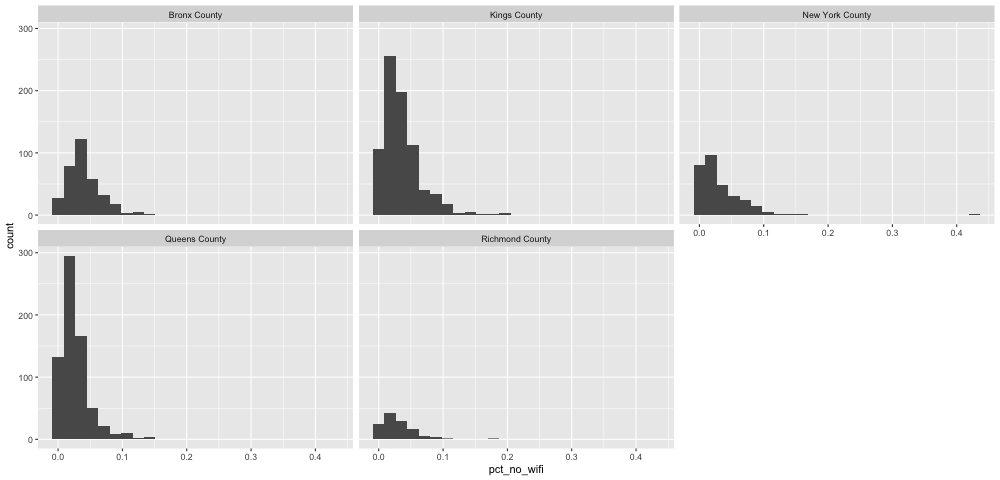

In [11]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=pct_no_wifi) +
    geom_histogram(bins = 25) + 
    facet_wrap(~borough) 


# your code here. refer to example notebooks for help


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 84 rows containing non-finite outside the scale range
(`stat_boxplot()`). 

R[write to console]: 2: Removed 84 rows containing missing values or values outside the scale range
(`geom_point()`). 



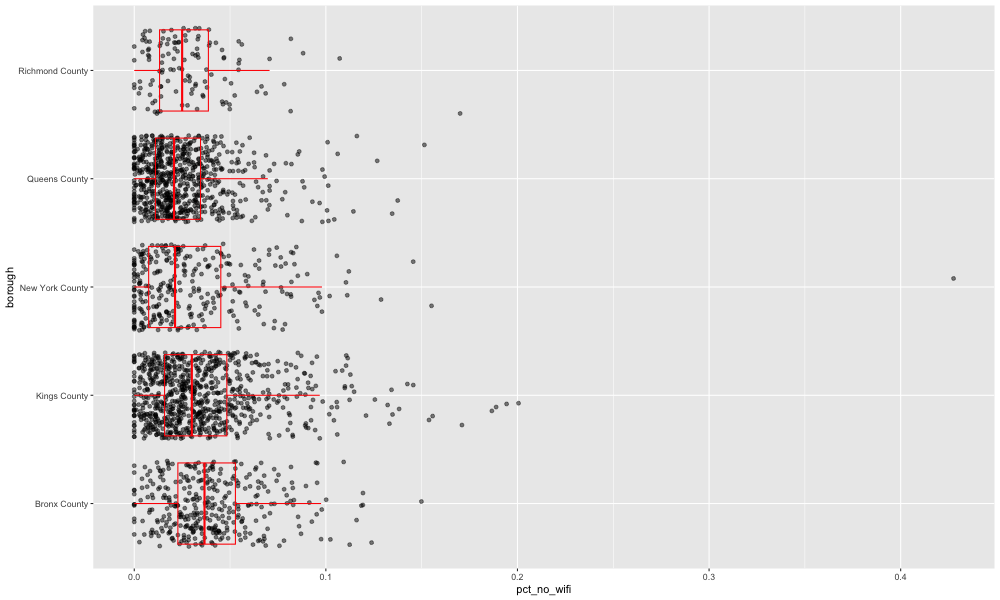

In [12]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=pct_no_wifi, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

In [17]:
%%R -w 1000 -h 1000

# your code here. refer to example notebooks for help
wifi_map = nyc_census_data %>%
      ggplot(aes(fill = pct_no_wifi)) + 
      geom_sf(color = NA) + 
      scale_fill_gradient(low="white", high="red") + 
      theme_minimal() +
      labs(
        title = "There seems like a part of mid-town Manhattan doesn't have access to the Internet. What's up with that?",
        subtitle = "Percentage of population without Internet access by census tract in NYC",
        caption = "Source: US Census Bureau"
      ) +
      theme(
        #make title and subitle bigger
        plot.title = element_text(size = 13),
        plot.subtitle = element_text(size = 8),
        # move legend to top
        legend.position = "top"
      )

In [19]:
%%R

library(ggplot2)

ggsave(filename = "/Users/tiffsmacbookair/Algorithms/ggplot-census-tiff-xwang/wifi_map.jpg", plot = wifi_map, width = 13, height = 8, dpi = 300)